# Visualize Simulated Boycott Results

In [1]:
from collections import defaultdict
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="dark")
from scipy import stats

from scipy.interpolate import interp1d

NUM_USERS = 6040

First things first: let's load our master data file (a single, aggregated csv)
and take a glance at the data.

In [2]:
# old_df = pd.read_csv('all_results_v01.csv', dtype={'indices': str})
df = pd.read_csv('all_results.csv', dtype={'indices': str})
print(len(df.index))
df = df[df.ratingfrac.notna()]

print(len(df.index))

13786
10856


Let's apply transformation that will affect the entire dataframe.
1. Calculate the number of users included in each experiment.

In [3]:
df = df.assign(num_users_boycotting = [NUM_USERS - int(x) for x in df.num_users])
# drop columns we're not going to use.
drops = [
    #'tail',
]
for column in df.columns.values:
    for drop in drops:
        if drop in column:
            df = df.drop(column, axis=1)

# old_df = old_df.assign(num_users_boycotting = [NUM_USERS - int(x) for x in old_df.num_users])

Define all the lists that can be used throughout. By editing this cell we can easily modify the full notebook.

In [4]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users', 'num_users_boycotting']
id_vars = [x for x in id_vars if x in list(df.columns.values)]
metrics = [
    # 'rmse',
    'ndcg10',
    'tailndcg10',
    # 'ndcgfull',
    'prec10t4',
    'tailprec10t4',
]

metrics2 = [
    'prec10t4', 'tailprec10t4'
]

organized_experiments = [
    'gender', 'age', 'state',
    'occupation', 'power', 'genre',
    'genre_strict',
]
algo_names = [
    'KNNBaseline_item_msd',
    'SVD'
]
standard_algo_names = ['KNNBaseline_item_msd', 'SVD', 'GlobalMean', 'MovieMean', 'GuessThree']
standard_results = {}
algo_to_metric_vs_global_mean = defaultdict(dict)
algo_to_metric_vs_movie_mean = defaultdict(dict)
algo_to_metric_vs_guess_three = defaultdict(dict)
algo_to_metric_vs_knn = defaultdict(dict)

for algo_name in standard_algo_names:
    filename_ratingcv_standards = 'standard_results/{}_ratingcv_standards_for_{}.json'.format(
        'ml-1m', algo_name)
    with open(filename_ratingcv_standards, 'r') as f:
        standard_results[algo_name] = json.load(f)
for main_algo_name in algo_names:
    for metric in metrics:
        goodval = standard_results[main_algo_name].get(metric, 0)
        print('goodval', goodval)
        gmean = standard_results['GlobalMean'][metric]
        mmean = standard_results['MovieMean'].get(metric, 0)
        guess_three = standard_results['GuessThree'][metric]
        knn = standard_results['KNNBaseline_item_msd'][metric]
        algo_to_metric_vs_global_mean[main_algo_name][metric] = (gmean - goodval) / goodval * 100 if goodval else 0
        algo_to_metric_vs_movie_mean[main_algo_name][metric] = (mmean - goodval) / goodval * 100 if goodval else 0
        algo_to_metric_vs_guess_three[main_algo_name][metric] = (guess_three - goodval) / goodval * 100 if goodval else 0
        algo_to_metric_vs_knn[main_algo_name][metric] = (knn - goodval) / goodval * 100 if goodval else 0

print('movie', algo_to_metric_vs_movie_mean)
print('standards', standard_results['SVD'])

goodval 0.7917576771996123
goodval 0.7707049537755648
goodval 0.7996180529706427
goodval 0.7555507250557071
goodval 0.7934699275627399
goodval 0.7729129845829772
goodval 0.8035561666164517
goodval 0.7576885503570141
movie defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'ndcg10': -2.316653111465638, 'tailndcg10': -1.8543996226268522, 'prec10t4': -1.7771582229651413, 'tailprec10t4': -1.4097354325029365}, 'SVD': {'ndcg10': -2.527446665665193, 'tailndcg10': -2.134778544404378, 'prec10t4': -2.258534297970622, 'tailprec10t4': -1.6879087821670382}})
standards {'rmse': 0.8738937258268422, 'mae': 0.6861695403414771, 'prec10t4': 0.8035561666164517, 'prec10t4_frac_all': 0.991717904358947, 'prec5t4': 0.8304768112820538, 'prec5t4_frac_all': 0.991717904358947, 'rec10t4': 0.6400262515264532, 'rec10t4_frac_all': 0.991717904358947, 'rec5t4': 0.44194009353716285, 'rec5t4_frac_all': 0.991717904358947, 'ndcg10': 0.7934699275627399, 'ndcg10_frac_all': 0.7253695896398364, 'ndcg5': 0.7845470579242851, 

In [5]:
0.803556166616451 - (0.803556166616451 * (1 - 0.004889779445720951))

0.003929212427003503

In [6]:
algo_to_metric_to_slope = defaultdict(dict)
algo_to_metric_to_intercept = defaultdict(dict)
algo_to_metric_to_average_boycott = defaultdict(dict)

In [7]:
samples_df = df[df['type'] == 'sample_users']
if not samples_df.empty:
    print(samples_df[['name', 'num_users', 'num_users_boycotting']].head())
org_df = df[df['type'].isin(organized_experiments)]

                  name  num_users  num_users_boycotting
3536  1208 user sample       4832                  1208
3538  1208 user sample       4832                  1208
3539  1208 user sample       4832                  1208
3541  1208 user sample       4832                  1208
3542  1208 user sample       4832                  1208


In [8]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('US_', '')
    .replace('state', '')
    .strip()
    for x in list(org_df.name)
]

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


First, let's see how well the # of ratings correlates with error.
This will be an important piece of context for analyzing the experiments.

In [9]:
# for algo_name in algo_names:
#     filt = org_df[org_df.algo_name == algo_name]
#     for metric in metrics:
#         key = 'percent_increase_{}_non-boycott'.format(metric)
#         sns.jointplot(filt.num_ratings, y=filt[key], kind="reg").fig.suptitle(algo_name)
#         plt.show()
#         slope, intercept, r_value, p_value, std_err = stats.linregress(filt.num_ratings, y=filt[key])
#         print(slope, intercept, r_value, p_value)
#         algo_to_metric_to_slope[algo_name][metric] = slope
#         algo_to_metric_to_intercept[algo_name][metric] = intercept
        
#         # calculate the average error for all boycott users in each dataframe
#         algo_to_metric_to_average_boycott[algo_name][metric] = np.mean(
#             samples_df[(
#                 (samples_df.algo_name == algo_name) &
#                 (samples_df.userfrac == 1.0) & 
#                 (samples_df.ratingfrac == 1.0)
#             )][key.replace('non-boycott', 'boycott')]
#         )

In [10]:
def select_cols(cols, metrics, groups, percents):
    """take a list of cols and filter based on metrics/groups/percents"""
    increase_cols = [
        x for x in cols if (any(metric in x for metric in metrics) and 'increase' in x)
    ]
    increase_cols = [
        x for x in increase_cols if any(group == x.split('_')[-1] for group in groups)
    ]
    if percents:
        increase_cols = [x for x in increase_cols if 'percent' in x]
    else:
        increase_cols = [x for x in increase_cols if 'percent' not in x]
    return increase_cols

In [11]:
def fill_in_longform(df):
    """Fill in a longform dataframe with metric, group, and name information"""
    df = df.assign(
        metric=[x.split('_')[-2] for x in df.increase_type]
    )
    df = df.assign(
        group=[x.split('_')[-1] for x in df.increase_type]
    )
    return df
    

In [17]:
def p_b_curve(
        df, metrics, groups, percents=False, lm_plot=True,
        reg_plot=False, hue='group', row='metric',
        normalize_by_baseline=False
    ):
    algo_to_metric_to_interp = defaultdict(dict)
    if lm_plot:
        increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
        increase_cols = [x for x in increase_cols if 'vanilla' not in x]
        print('2', increase_cols)
        longform = df[increase_cols + id_vars].melt(
            id_vars = id_vars,
            var_name='increase_type'
        )
        longform = fill_in_longform(longform)
        
        
        
        
        grid = sns.lmplot(
            x="num_users_boycotting", y="value", hue=hue, data=longform,
            sharey='row', sharex='col',
            size=10, row=row, col='algo_name',
            fit_reg=False,
            x_estimator=np.mean, ci=99,
        )
        # CALC LOG PLOT
#         vals = [float(x) for x in list(longform.value)]
#         minval = np.min(vals)
#         shifted = vals + - minval + 0.00001
#         print(np.min(shifted))
#         longform = longform.assign(logy = np.log2(shifted))
#         g = sns.lmplot(
#             x="num_users_boycotting", y="logy", hue="algo_name", data=longform,
#             size=6, row='metric',
#             x_estimator=np.mean,
#             order=2
#         )
    
    for metric in metrics:
        for algo_name in algo_names:
            filt = df[df.algo_name == algo_name]
            key = 'increase_{}_non-boycott'.format(metric)
            if percents:
                key = 'percent_' + key
            x = filt.num_users_boycotting
            user_nums = list(set(filt.num_users_boycotting))
            y = filt[key]
            
            num_to_mean = {}
            for num_users_boycotting in user_nums:
                filt_by_name = filt[filt.num_users_boycotting == num_users_boycotting]
                # print('1', len(filt_by_name[key]))
                num_to_mean[num_users_boycotting] = np.mean(filt_by_name[key])
                
            for num in [1, 3, 604, 1812]:
                val = num_to_mean[num]
                print(
                    'Algo:{}|Metric:{}|#users:{}'.format(
                        algo_name, metric, num, 
                    )
                )
                print('Val:{}|Ratio:{}'.format(
                    val,
                    val / algo_to_metric_vs_movie_mean[algo_name][metric]
                ))
            meany = np.array(list(num_to_mean.values()))
            
            smoothf = interp1d(user_nums, meany, kind='linear', bounds_error=False, fill_value='extrapolate')
            algo_to_metric_to_interp[algo_name][metric] = smoothf
            xnew = np.linspace(min(user_nums), max(user_nums), num=500)
            if reg_plot:
                _, ax = plt.subplots()
                g = sns.regplot(
                    x=x, y=y,
                    x_estimator=np.mean,
                    x_bins=user_nums,
                    ax=ax,
                    ci=99,
                    fit_reg=False,
                )
                g.set_title(algo_name)
                
                plt.plot(xnew, smoothf(xnew), '-')
                plt.axhline(0, color='0.5', linestyle='--')
                plt.axhline(algo_to_metric_vs_movie_mean[algo_name][metric], color='0.5', linestyle='--')
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        group = grid.hue_names[i_hue]
        if group != 'non-boycott':
            continue
        ax = grid.axes[i_row, i_col]
        ynew = algo_to_metric_to_interp[algo_name][metric](xnew)
        ax.plot(xnew, ynew, '-', color=grid._colors[i_hue])
        ax.axhline(0, color='0.5', linestyle='--')
        ax.axhline(algo_to_metric_vs_movie_mean[algo_name][metric], color='0.5', linestyle='--')
        plt.setp(ax.get_xticklabels(), visible=True, rotation=45)
        if algo_name == 'SVD':
            ax.axhline(algo_to_metric_vs_knn[algo_name][metric], color='g', linestyle='--')
    plt.subplots_adjust(hspace=0.3)
#     for metric in metrics:
#         for algo_name in algo_names

    return algo_to_metric_to_interp


Working through log plots
y = log(x)
y = e ^ x
ln(y) = x

2 ['percent_increase_ndcg10_all', 'percent_increase_ndcg10_non-boycott', 'percent_increase_prec10t4_all', 'percent_increase_prec10t4_non-boycott', 'percent_increase_tailndcg10_all', 'percent_increase_tailndcg10_non-boycott', 'percent_increase_tailprec10t4_all', 'percent_increase_tailprec10t4_non-boycott']
Algo:KNNBaseline_item_msd|Metric:ndcg10|#users:1
Val:0.07644768865354386|Ratio:-0.03299919538026087
Algo:KNNBaseline_item_msd|Metric:ndcg10|#users:3
Val:0.07408900172853722|Ratio:-0.031981051181920184
Algo:KNNBaseline_item_msd|Metric:ndcg10|#users:604
Val:-0.014651858481691087|Ratio:0.006324580235675224
Algo:KNNBaseline_item_msd|Metric:ndcg10|#users:1812
Val:-0.22959792742778434|Ratio:0.09910759892858041
Algo:SVD|Metric:ndcg10|#users:1
Val:0.06714763993956971|Ratio:-0.026567381560115837
Algo:SVD|Metric:ndcg10|#users:3
Val:0.06759928873397454|Ratio:-0.026746079215951818
Algo:SVD|Metric:ndcg10|#users:604
Val:-0.13341864699310452|Ratio:0.052787917864130424
Algo:SVD|Metric:ndcg10|#users:1

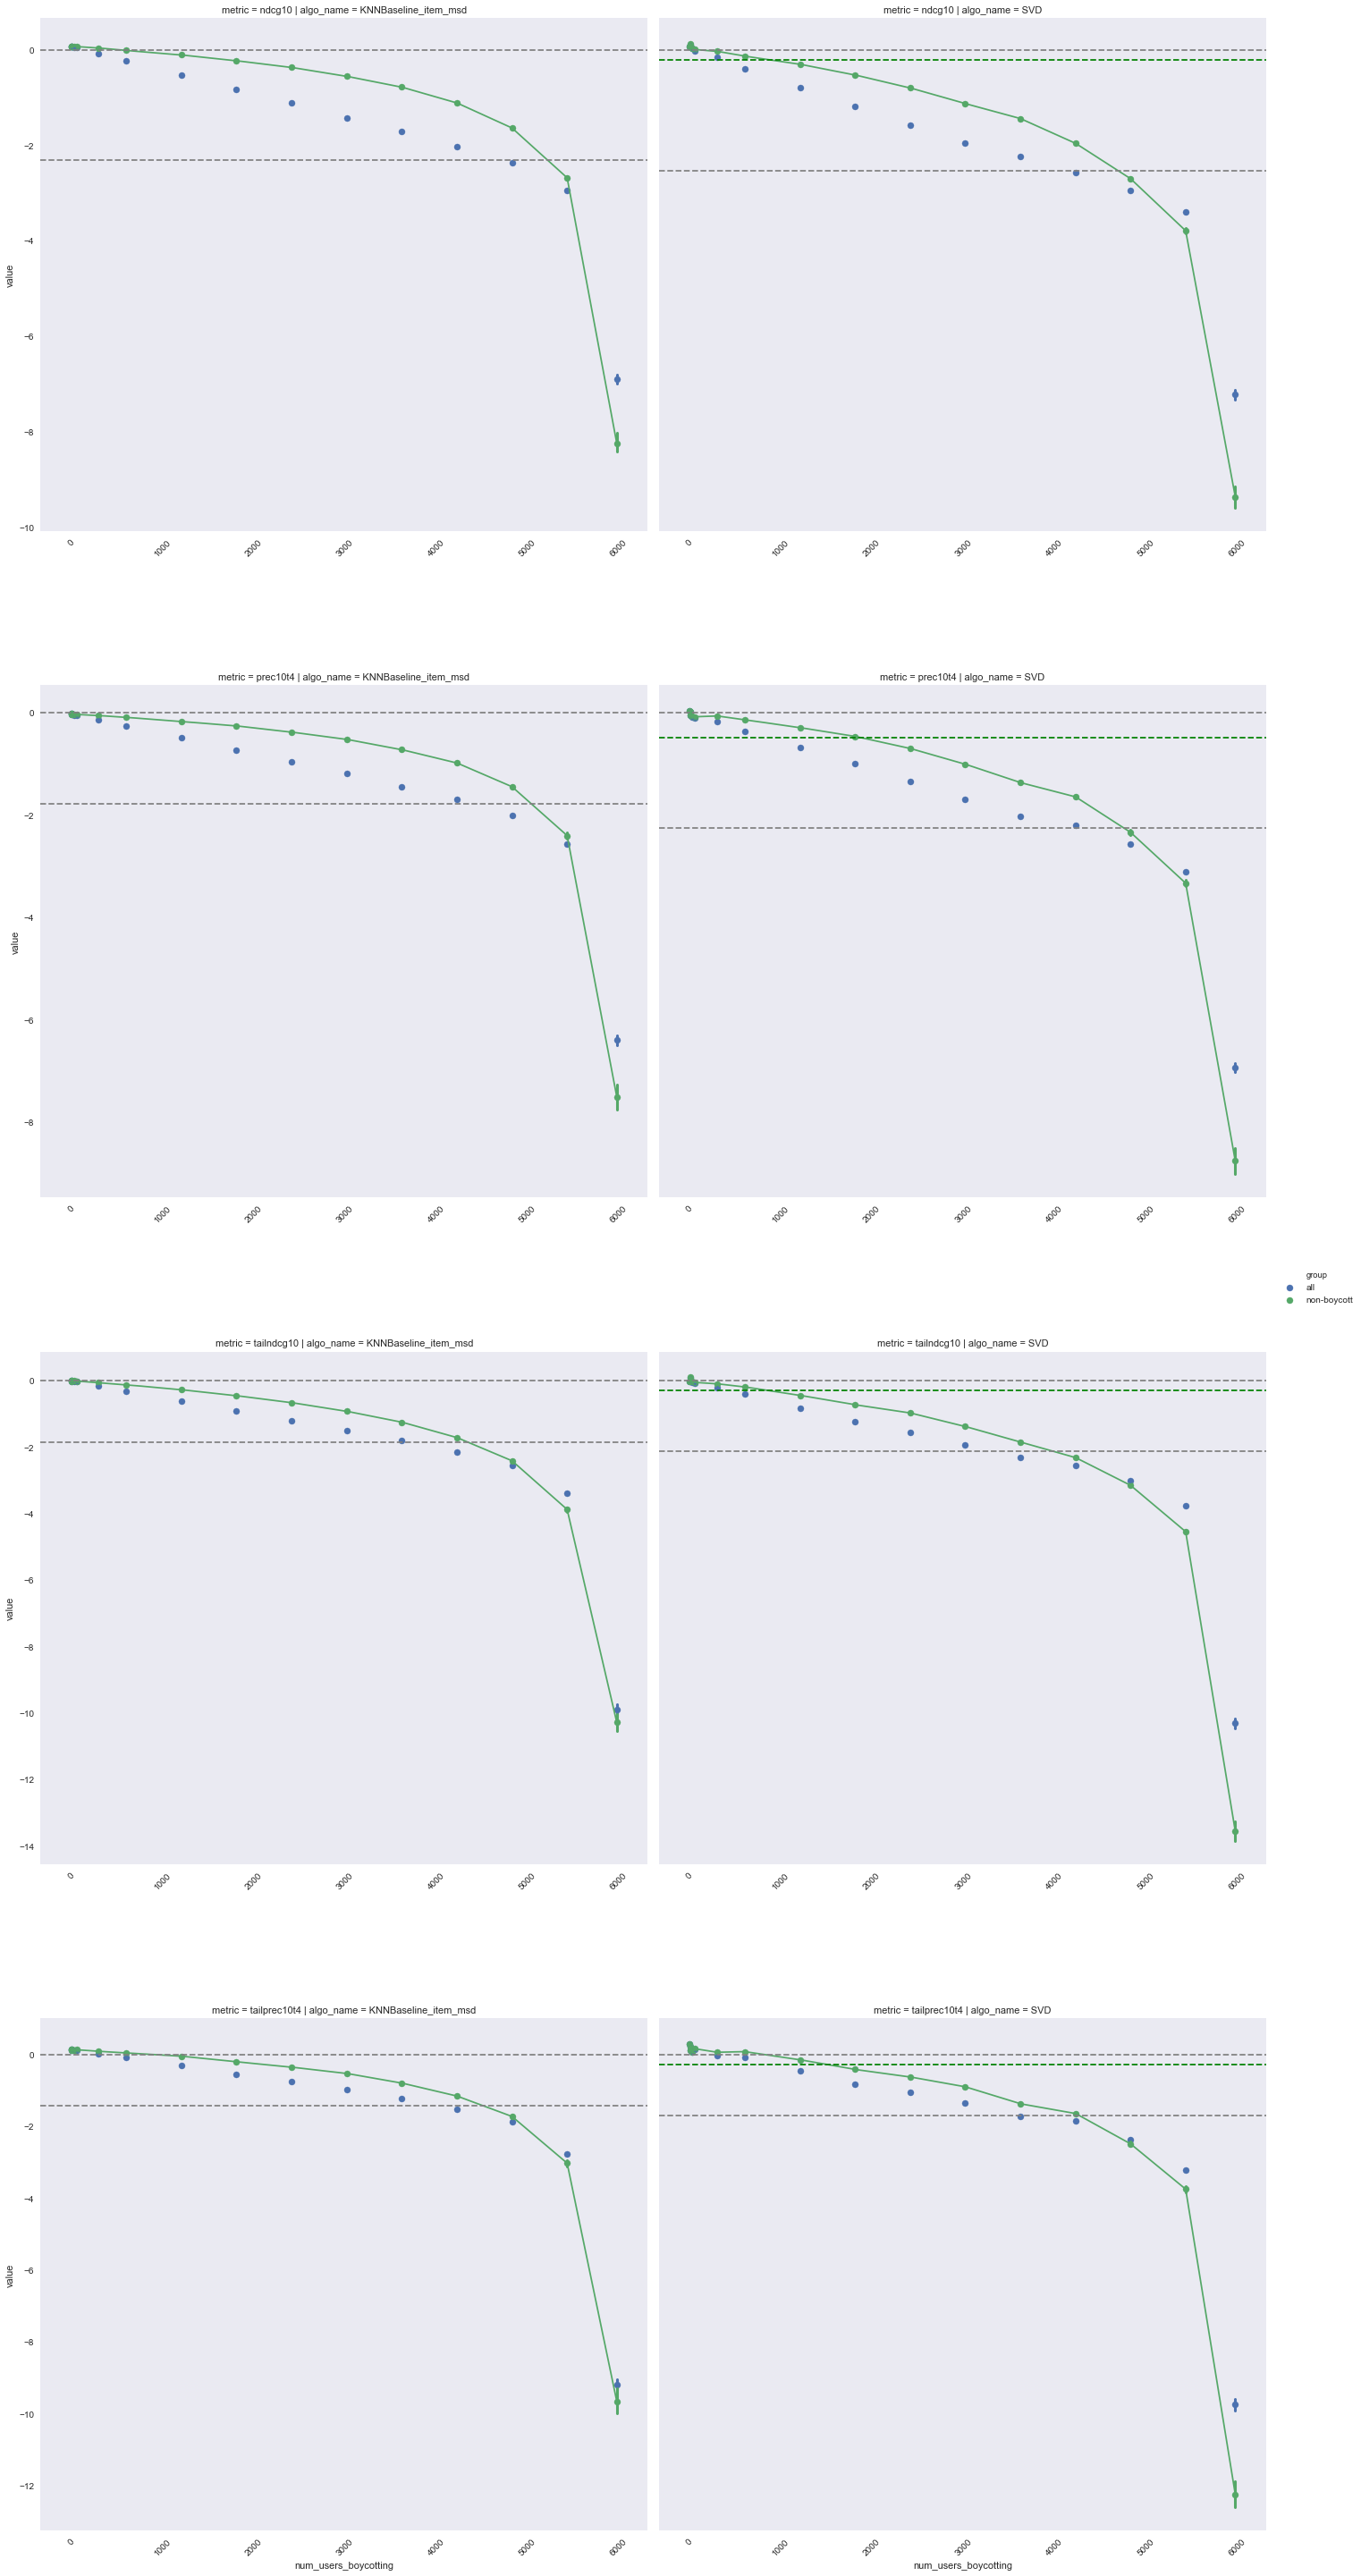

In [18]:
algo_to_metric_to_interp = p_b_curve(
    samples_df,
    metrics=metrics,
    percents=True,
    groups=['non-boycott', 'all', ]
)
plt.show()

2 ['percent_increase_prec10t4_non-boycott', 'percent_increase_tailprec10t4_non-boycott']
Algo:KNNBaseline_item_msd|Metric:prec10t4|#users:604
Val:-0.0891485250833807|Ratio:0.05016352732771241
Algo:KNNBaseline_item_msd|Metric:prec10t4|#users:1812
Val:-0.2563528338868216|Ratio:0.14424873968683763
Algo:SVD|Metric:prec10t4|#users:604
Val:-0.1364052501170239|Ratio:0.06039547428595136
Algo:SVD|Metric:prec10t4|#users:1812
Val:-0.46005409664268687|Ratio:0.20369586463932063
Algo:KNNBaseline_item_msd|Metric:tailprec10t4|#users:604
Val:0.048355979495417555|Ratio:-0.03430145712487568
Algo:KNNBaseline_item_msd|Metric:tailprec10t4|#users:1812
Val:-0.19981757912523126|Ratio:0.1417411909484761
Algo:SVD|Metric:tailprec10t4|#users:604
Val:0.08390215941536676|Ratio:-0.04970775690120419
Algo:SVD|Metric:tailprec10t4|#users:1812
Val:-0.4124844089051856|Ratio:0.24437600731931347


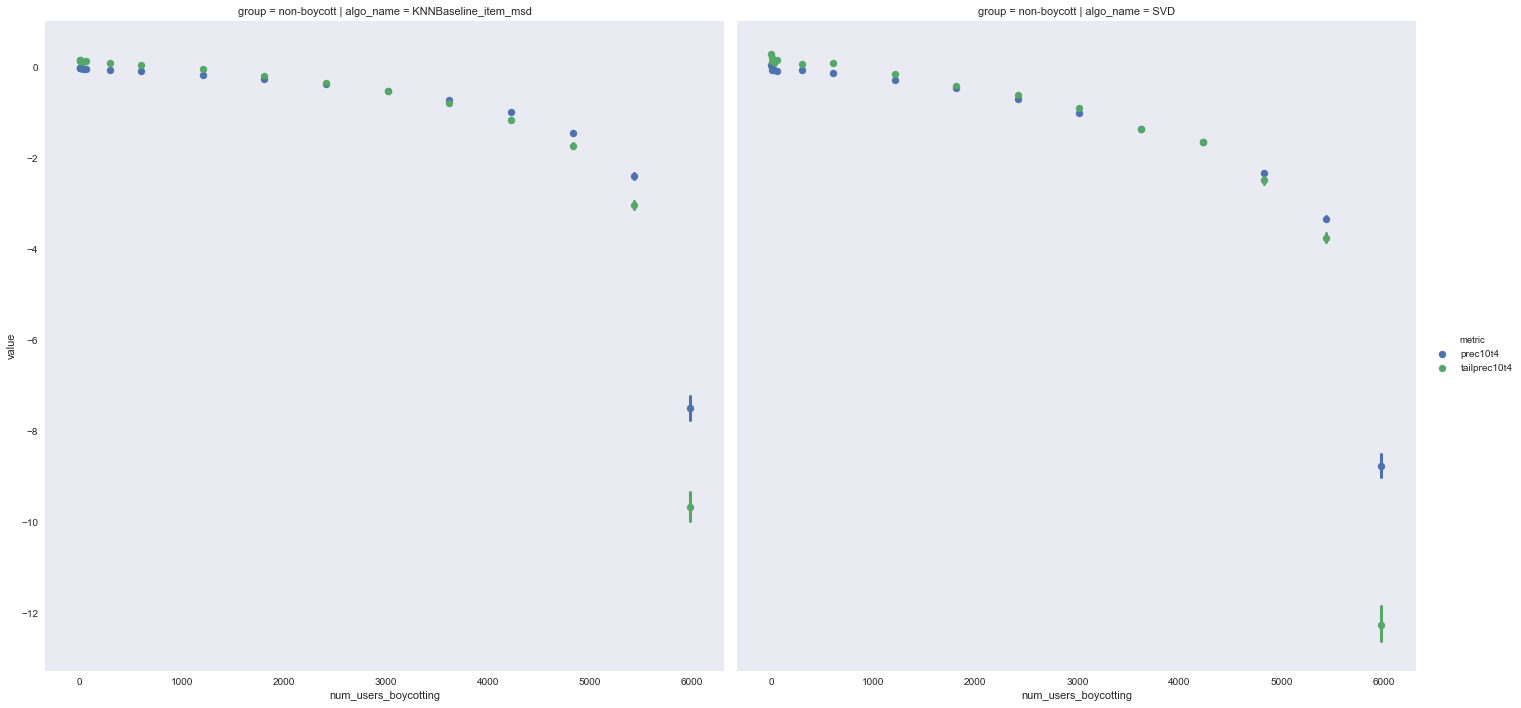

In [16]:
p_b_curve(
    samples_df,
    metrics=metrics2,
    percents=True,
    groups=['non-boycott', ],
    hue='metric',
    row='group',
)
plt.show()

In [1183]:
for metric in metrics:
    for algo_name in algo_names:
        key = 'percent_increase_{}_expected'.format(metric)
        expected_vals = algo_to_metric_to_interp[algo_name][metric](org_df.num_users_boycotting)
        print(key)
        kwargs = {key: expected_vals}
        org_df = org_df.assign(**kwargs)

percent_increase_ndcg10_expected
percent_increase_ndcg10_expected
percent_increase_tailndcg10_expected
percent_increase_tailndcg10_expected
percent_increase_prec10t4_expected
percent_increase_prec10t4_expected
percent_increase_tailprec10t4_expected
percent_increase_tailprec10t4_expected


In [1184]:
algo_to_metric_vs_movie_mean

defaultdict(dict,
            {'KNNBaseline_item_msd': {'ndcg10': -2.316653111465638,
              'prec10t4': -1.7771582229651413,
              'tailndcg10': -1.8543996226268522,
              'tailprec10t4': -1.4097354325029365},
             'SVD': {'ndcg10': -2.527446665665193,
              'prec10t4': -2.258534297970622,
              'tailndcg10': -2.134778544404378,
              'tailprec10t4': -1.6879087821670382}})

In [1185]:
def plot2(df, metrics, groups, percents=False, kind='bar', size=10):
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    longform = longform.assign(
        name_plus_ratings=['{} ({}k)'.format(
            name, int(round(num_ratings/1000,0))
        ) for name, num_ratings in zip(longform.name, longform.num_ratings)
    ])
    grid = sns.factorplot(
        x="value", y="name", hue="group", data=longform,
        size=size, kind=kind, col='algo_name', row='metric',
        sharex=False,
        row_order=metrics,
        # linestyles='None',
        # capsize=0.1
    )
    a = grid.axes
    
    for metric in metrics:
        for col in increase_cols:
            if metric in col and 'expected' in col:
                expec = col
    
    total = 0
    total_sig = 0
    for x in grid.facet_data():
        i_row, i_col, i_hue = x[0]
        metric = grid.row_names[i_row]
        algo_name = grid.col_names[i_col]
        if grid.hue_names:
            group = grid.hue_names[i_hue]
        val = algo_to_metric_vs_movie_mean[algo_name].get(metric, 0)
        grid.axes[i_row, i_col].axvline(0, color='0.5', linestyle='--')
        grid.axes[i_row, i_col].axvline(val, color='0.5', linestyle='--')
        
        for col in increase_cols:
            if metric == col.split('_')[-2]:
                if 'expected' in col:
                    expec = col
                elif 'non-boycott' in col:
                    nb = col
        for name in list(set(longform.name)):
            mask = (
                (longform.metric == metric) &
                (longform.algo_name == algo_name) &
                (longform.name == name)
            )
            print('{} {} {}, {}, {}'.format(metric, algo_name, name, expec, nb))
            masked = longform[mask]
            try:
                expec_arr = np.array(masked[masked.increase_type == expec].value)
                nb_arr = np.array(masked[masked.increase_type == nb].value)
                ratio = np.mean(nb_arr)/np.mean(expec_arr)
                pval = stats.ttest_ind(expec_arr, nb_arr, equal_var=False).pvalue
                
                total += 1
                if pval < 0.05 and abs(ratio) > 2 or abs(ratio) < 0.5:
                    print('**')
                    print('Ratio: {}, pval: {}'.format(ratio, pval))
                    total_sig += 1
            except Exception as err:
                pass
    print('{}/{}'.format(total_sig, total))
    return grid


In [1186]:
state_boycotts = org_df[org_df['type'] == 'state']
gender_boycotts = org_df[org_df['type'] == 'gender']
age_boycotts = org_df[org_df['type'] == 'age']
occupation_boycotts = org_df[org_df['type'] == 'occupation']
power_boycotts = org_df[org_df['type'] == 'power']
genre_boycotts = org_df[org_df['type'] == 'genre']
genre_strict_boycotts = org_df[org_df['type'] == 'genre_strict']

In [1187]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [1188]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0)
    )]

In [1189]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [1190]:
def plot_all_three_scenarios(df, size=6):
#     all_df = all_users_all_ratings(df)
#     if not all_df.empty:
#         plot2(
#             all_users_all_ratings(df),
#             metrics=metrics,
#             percents=True,
#             groups=['all', 'non-boycott', 'expected'],
#             size=size
#         ).fig.suptitle('All Users, All Ratings')
    
    half_users_df = half_users(df)
    if not half_users_df.empty:
        plot2(
            half_users_df,
            metrics=metrics,
            percents=True,
            groups=['non-boycott', 'like-boycott', 'expected'],
            size=size
        ).fig.suptitle('Half Users')
        
    half_ratings_df = half_ratings(df)
    if not half_ratings_df.empty:
        plot2(
            half_ratings_df,
            metrics=metrics,
            percents=True,
            groups=['non-boycott', 'boycott', 'like-boycott', 'expected'],
            size=size,
        ).fig.suptitle('Half Ratings')
    plt.show()

## Let's do gender first...

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


ndcg10 KNNBaseline_item_msd male users, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
ndcg10 KNNBaseline_item_msd female users, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
ndcg10 SVD male users, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
ndcg10 SVD female users, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: -0.4740438424911956, pval: 4.0186491874944e-13
tailndcg10 KNNBaseline_item_msd male users, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
tailndcg10 KNNBaseline_item_msd female users, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
**
Ratio: -0.04072816579510541, pval: 4.3056648693177515e-09
tailndcg10 SVD male users, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
tailndcg10 SVD female users, percent_increase_tailndcg10_expected, vanil

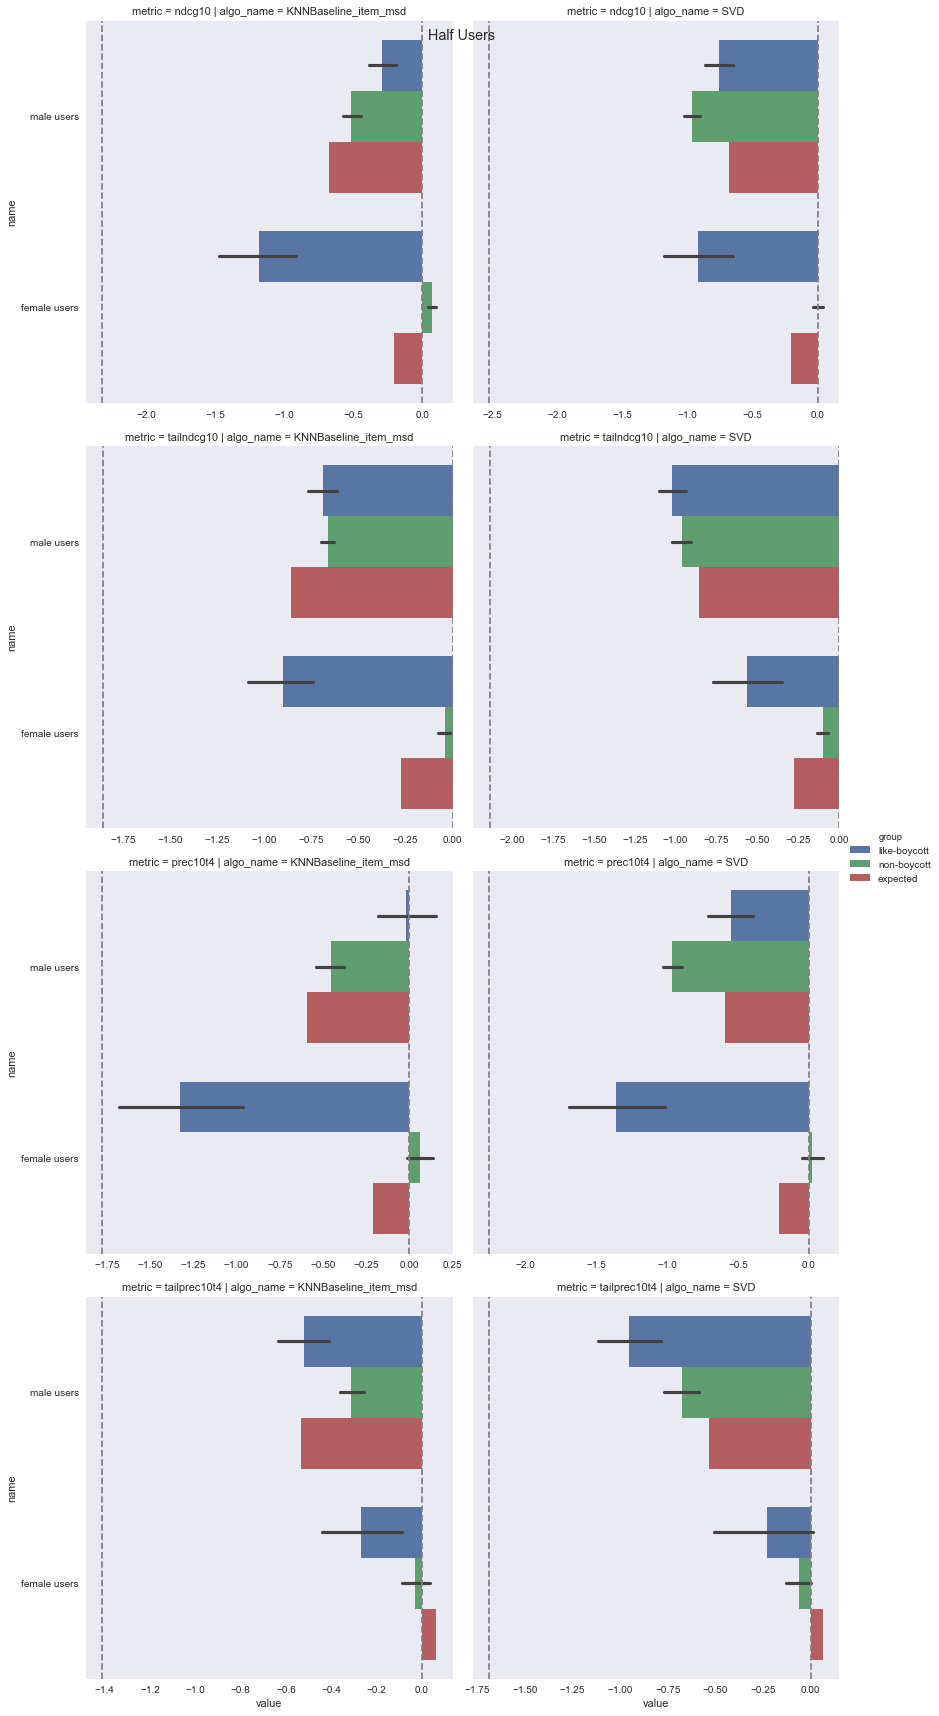

In [1191]:
plot_all_three_scenarios(gender_boycotts)

States seemed uninteresting and slowed the page down a bit, so I commented out for now.
Main conclusion was that state-based boycotts seem to be pretty ineffective for basically every state.
One funny result was that it seems California users have especially low-value ratings - the performance degradation was quite off from the expected degradation (b/c CA has a lot of users).

In [1192]:
# plot_all_three_scenarios(state_boycotts, size=12)

Below, the power boycotts show a very weird results. Warrants double checks.

It appears for KNN, removing all power users actually improves performance (as opposed to the large expected drop).
But at the same time, RMSE increases! This is one of the example where RMSE and NDCG do not correlate...

Note the artifact in plot #5 below: it looks like ndcg has a huge increase when bottom 10% users do a half boycott... but this is b/c ndcg@10 is just getting easier to "succeed" for these users

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


ndcg10 KNNBaseline_item_msd Top 10% contributors, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: -4.501454618037624, pval: 2.6966744209284893e-09
ndcg10 KNNBaseline_item_msd Bottom 10% contributors, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
ndcg10 SVD Top 10% contributors, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: 5.687065284737709, pval: 4.021858502288908e-07
ndcg10 SVD Bottom 10% contributors, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
tailndcg10 KNNBaseline_item_msd Top 10% contributors, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
**
Ratio: -6.792906249602529, pval: 6.662141265385302e-19
tailndcg10 KNNBaseline_item_msd Bottom 10% contributors, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
**
Ratio: -0.29665647059914274, pval: 7.977725814097282e-09
tailn

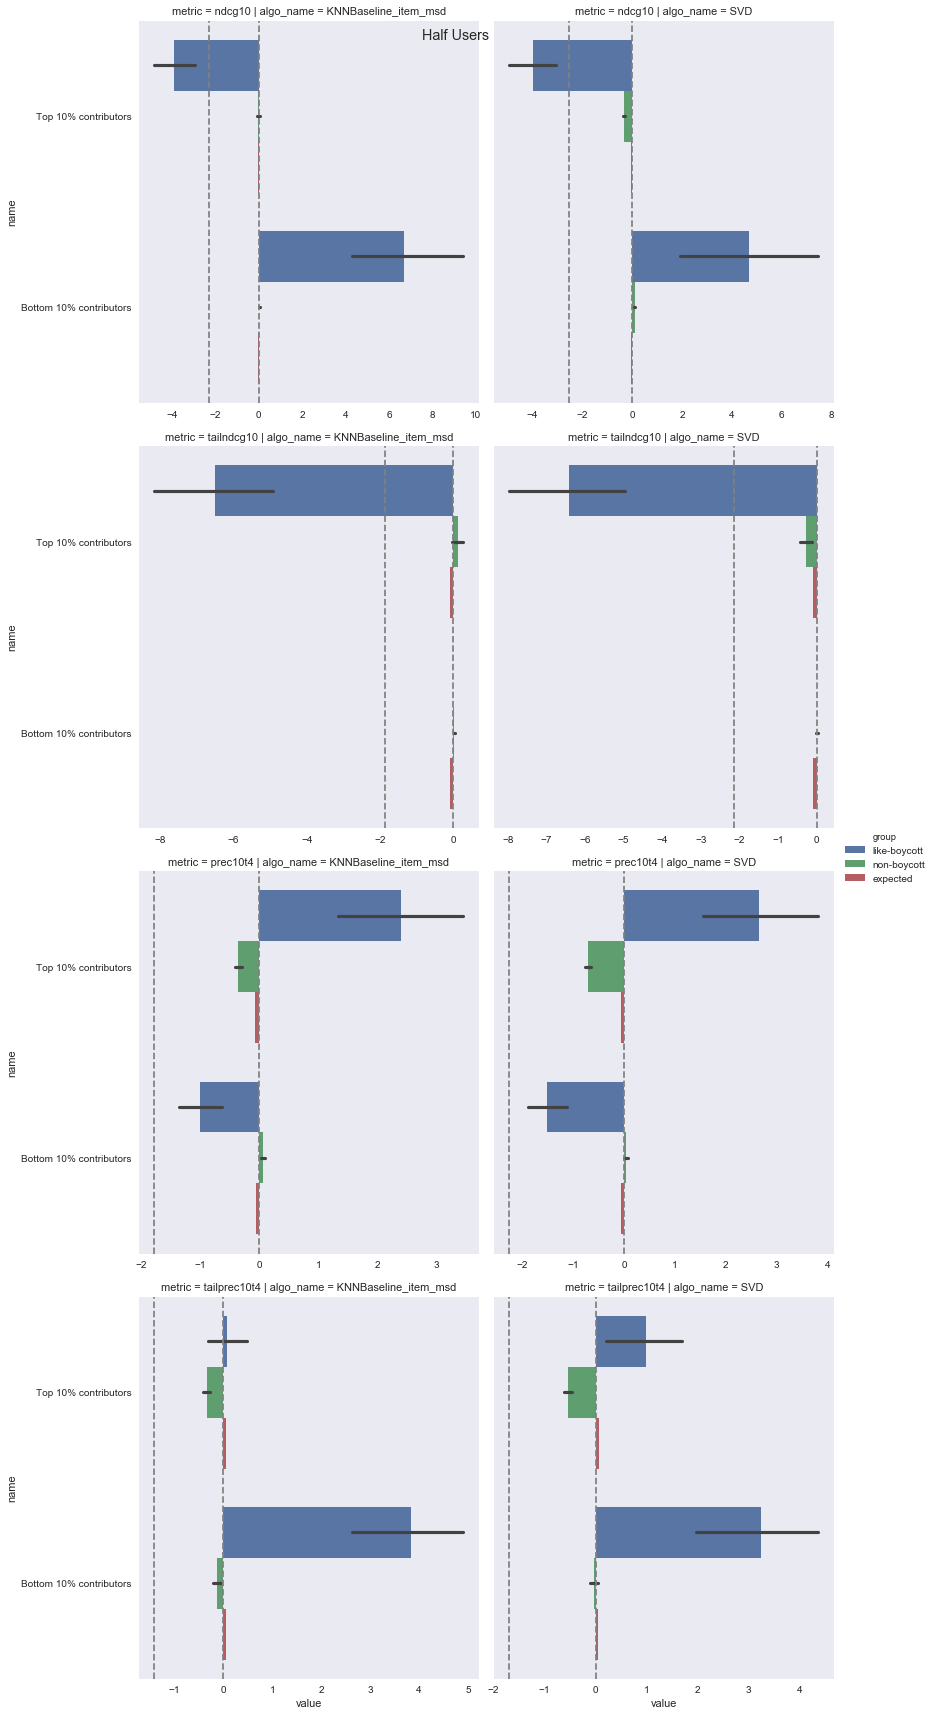

In [1193]:
plot_all_three_scenarios(power_boycotts)

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


ndcg10 KNNBaseline_item_msd 50-55, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: 7.893746364289321, pval: 3.6969883103932163e-07
ndcg10 KNNBaseline_item_msd 35-44, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: 0.4652503996326609, pval: 1.8995122012507343e-05
ndcg10 KNNBaseline_item_msd Under 18, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: -0.4760062999841984, pval: 0.002334428316818953
ndcg10 KNNBaseline_item_msd 25-34, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
ndcg10 KNNBaseline_item_msd 18-24, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
ndcg10 KNNBaseline_item_msd 45-49, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: 3.625966955074691, pval: 0.00011684826218300751
ndcg10 KNNBaseline_item_msd 56+, percent_increase_ndcg10_expected, vanillapercent_increase_n

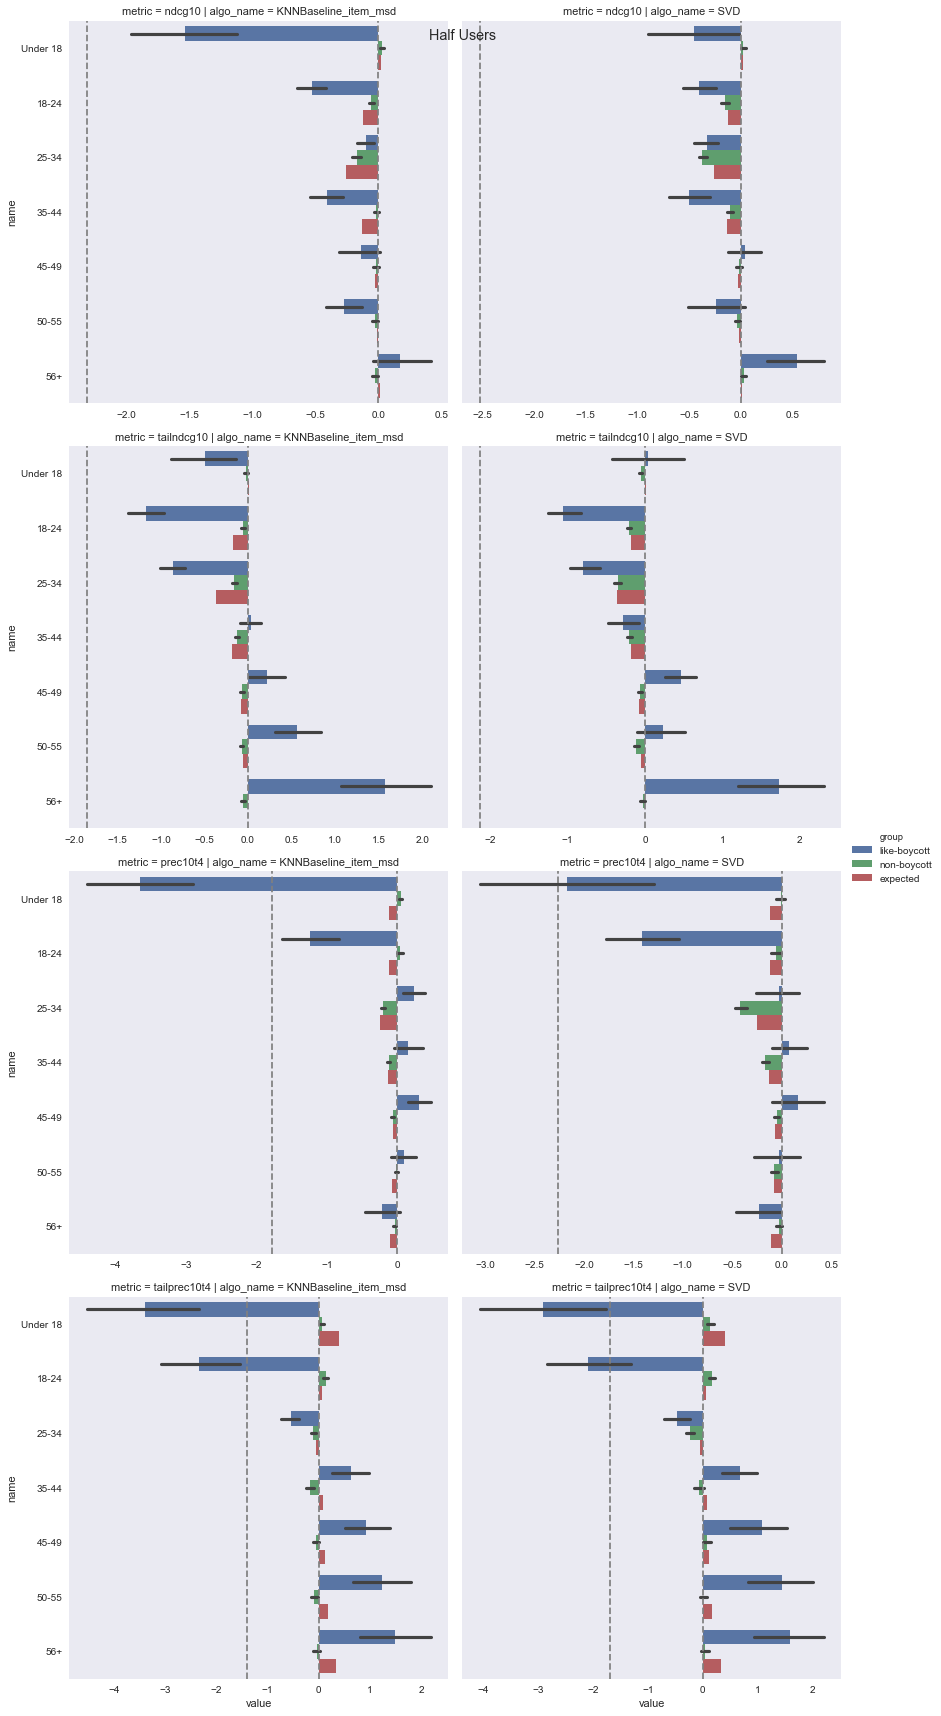

In [1194]:
plot_all_three_scenarios(age_boycotts)

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


ndcg10 KNNBaseline_item_msd lawyer, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: -10.984109311929847, pval: 9.04904025715161e-07
ndcg10 KNNBaseline_item_msd farmer, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: -0.40882805826529267, pval: 5.280148479284884e-13
ndcg10 KNNBaseline_item_msd technician/engineer, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: 10.311645564852249, pval: 5.705940753431796e-10
ndcg10 KNNBaseline_item_msd executive/managerial, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: 2.915688069992185, pval: 1.687426717746537e-06
ndcg10 KNNBaseline_item_msd scientist, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: -6.00018634117884, pval: 1.6138647317524588e-07
ndcg10 KNNBaseline_item_msd artist, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
n

**
Ratio: 2.397275748230764, pval: 0.02147166038966652
tailndcg10 SVD artist, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
tailndcg10 SVD customer service, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
**
Ratio: -0.05305253328915295, pval: 0.00040976744737438093
tailndcg10 SVD other, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
tailndcg10 SVD homemaker, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
**
Ratio: 0.42230437194704046, pval: 0.005953506365091056
tailndcg10 SVD doctor/health care, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
**
Ratio: -2.689463694800019, pval: 0.00011878266007473345
tailndcg10 SVD programmer, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
**
Ratio: 19.759223120644638, pval: 6.046213498181255e-07
tailndcg10 SVD retired, percent_i

**
Ratio: -0.46322577867251413, pval: 2.838533561746905e-06
tailprec10t4 KNNBaseline_item_msd other, percent_increase_tailprec10t4_expected, vanillapercent_increase_tailprec10t4_non-boycott
**
Ratio: -18.127937003883964, pval: 0.026603503309628684
tailprec10t4 KNNBaseline_item_msd homemaker, percent_increase_tailprec10t4_expected, vanillapercent_increase_tailprec10t4_non-boycott
tailprec10t4 KNNBaseline_item_msd doctor/health care, percent_increase_tailprec10t4_expected, vanillapercent_increase_tailprec10t4_non-boycott
**
Ratio: -0.44155194111323975, pval: 8.764613427955234e-18
tailprec10t4 KNNBaseline_item_msd programmer, percent_increase_tailprec10t4_expected, vanillapercent_increase_tailprec10t4_non-boycott
**
Ratio: -0.495284066294578, pval: 4.382744838818851e-14
tailprec10t4 KNNBaseline_item_msd retired, percent_increase_tailprec10t4_expected, vanillapercent_increase_tailprec10t4_non-boycott
tailprec10t4 KNNBaseline_item_msd college/grad student, percent_increase_tailprec10t4_expe

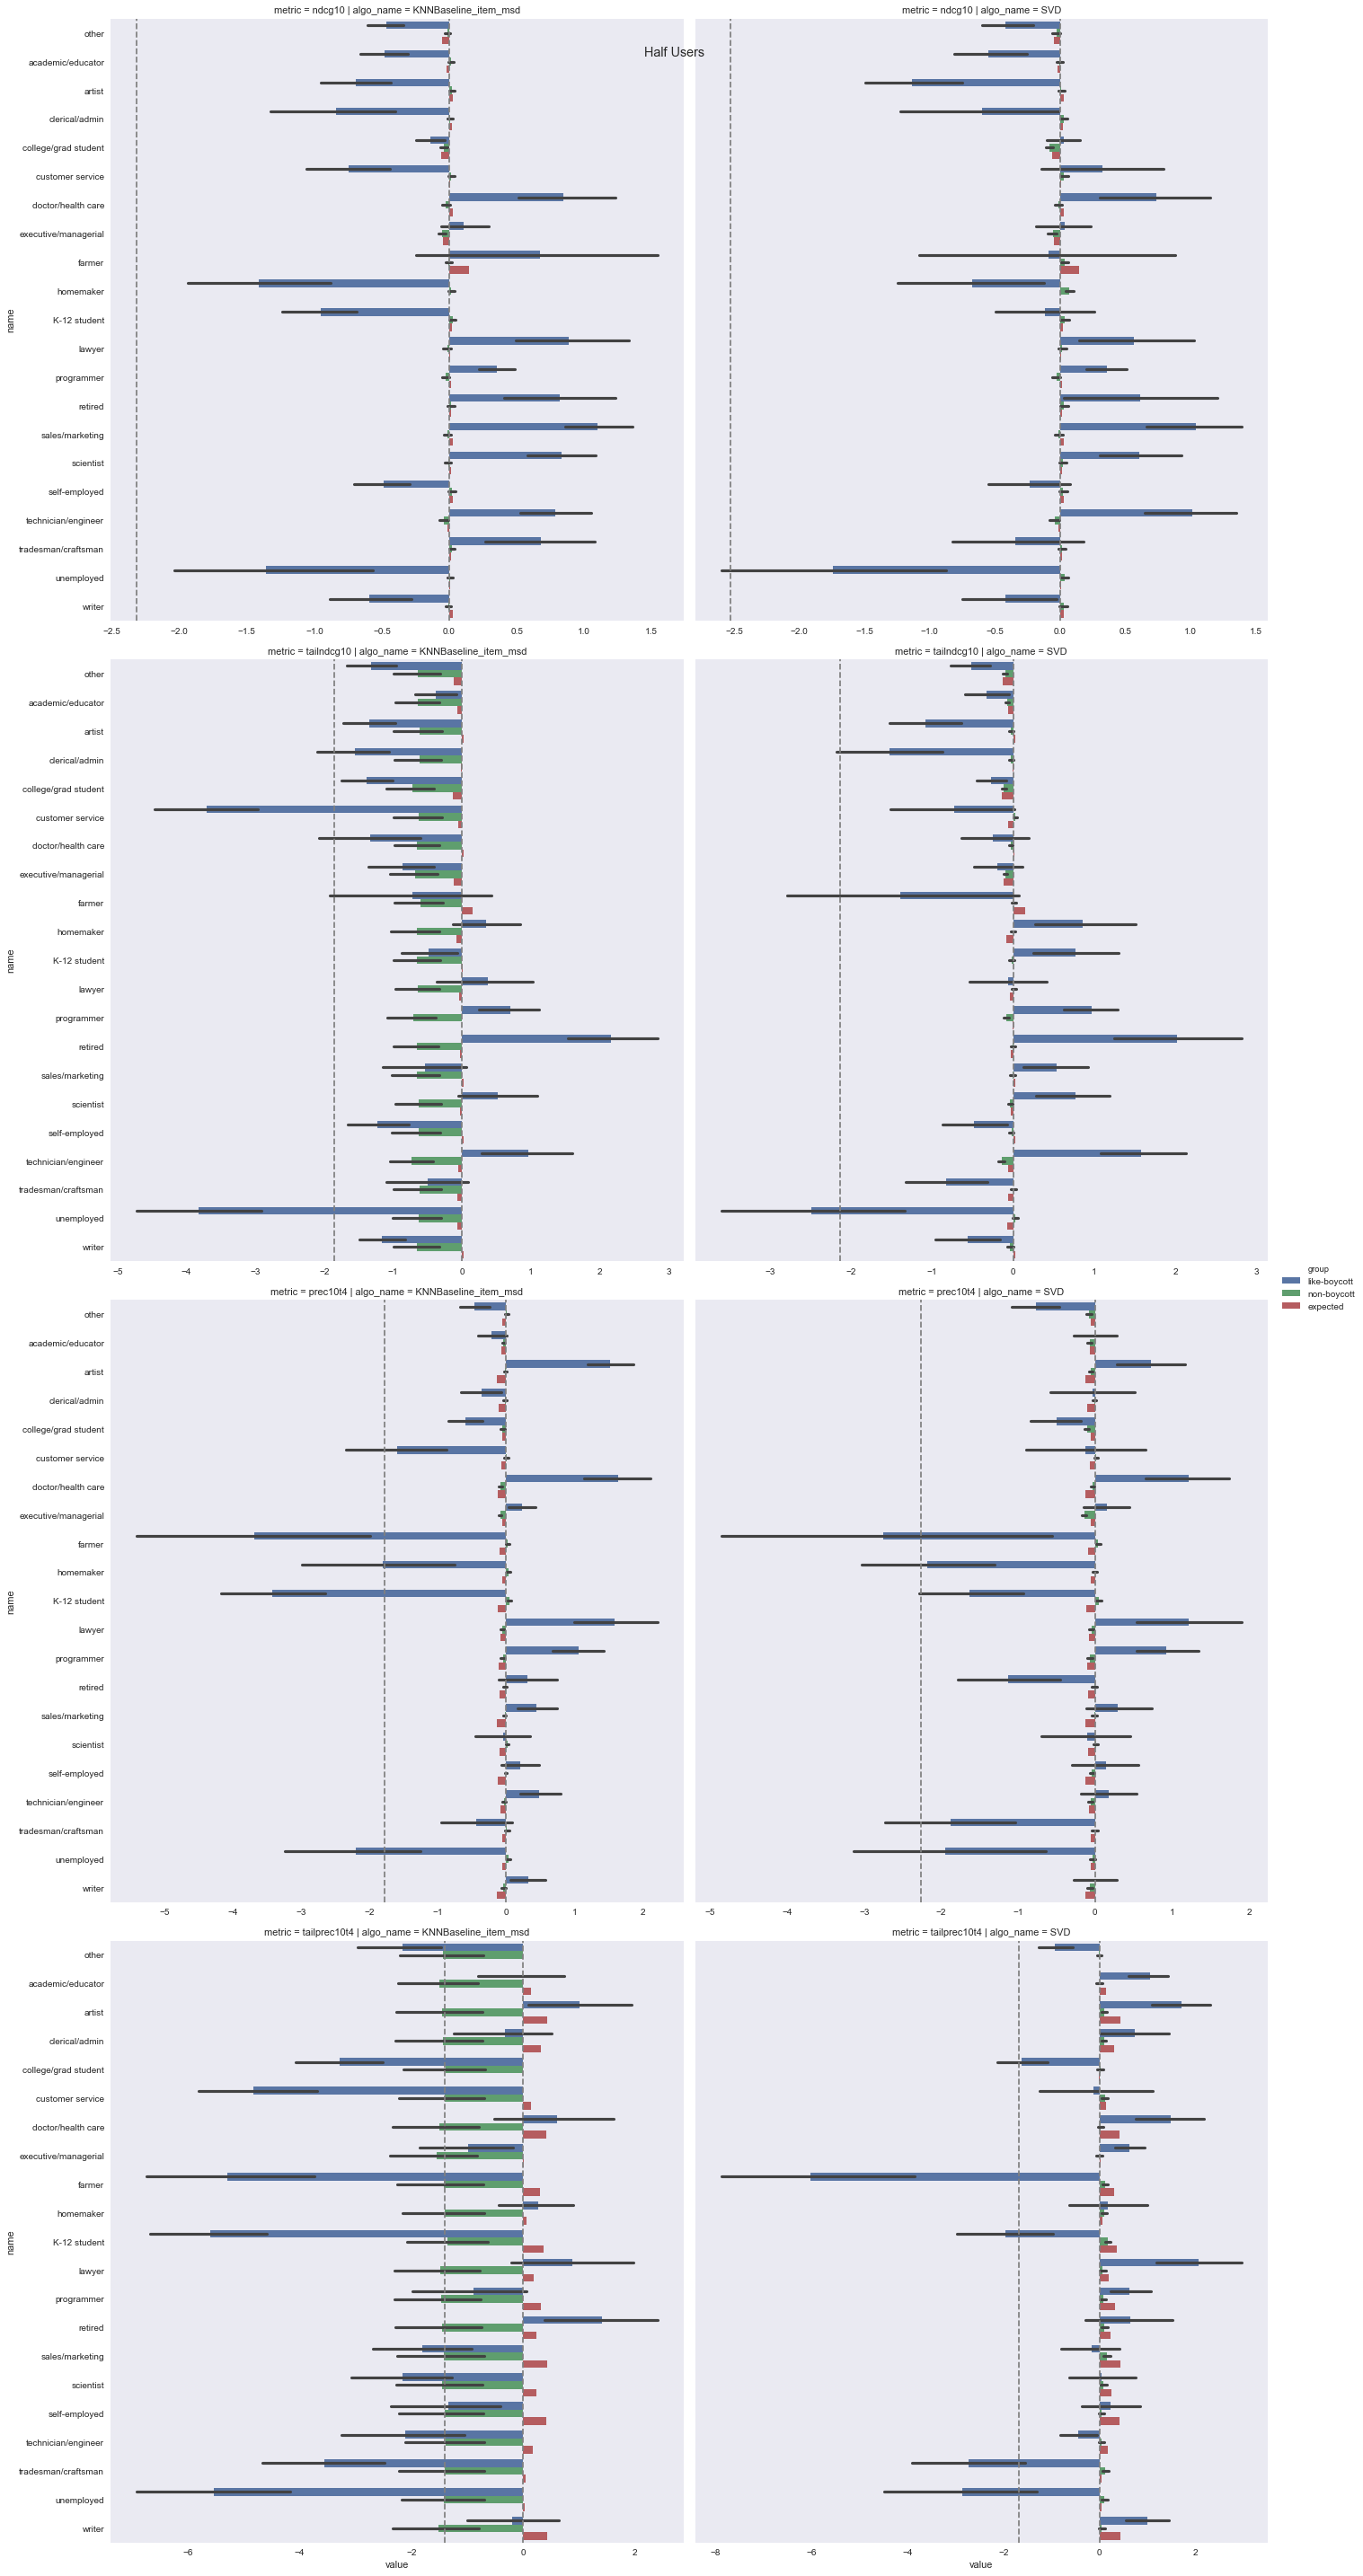

In [1195]:
plot_all_three_scenarios(occupation_boycotts, size=10)

C:\Users\Nick\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


ndcg10 KNNBaseline_item_msd Fans of Horror  using threshold 4, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: -8.991735220838269, pval: 1.2049649866695923e-12
ndcg10 KNNBaseline_item_msd Fans of War  using threshold 4, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: 5.330181358057036, pval: 1.2867192351380062e-18
ndcg10 KNNBaseline_item_msd Fans of Romance  using threshold 4, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: 7.770288508459742, pval: 5.953143855314711e-20
ndcg10 KNNBaseline_item_msd Fans of Sci-Fi  using threshold 4, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: 13.487912568838599, pval: 2.2274998888492604e-19
ndcg10 KNNBaseline_item_msd Fans of Action  using threshold 4, percent_increase_ndcg10_expected, vanillapercent_increase_ndcg10_non-boycott
**
Ratio: 7.27660957421227, pval: 3.5575570446249644e-21
ndcg10 KNNBa

Ratio: 5.613235322628809, pval: 3.520662288540501e-16
tailndcg10 SVD Fans of Action  using threshold 4, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
**
Ratio: 4.00349971036826, pval: 5.905500326632179e-17
tailndcg10 SVD Fans of Mystery  using threshold 4, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
**
Ratio: -14.661155012606704, pval: 4.244732543740631e-16
tailndcg10 SVD Fans of Fantasy  using threshold 4, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
**
Ratio: 3.3226090942278756, pval: 0.0017869164003174727
tailndcg10 SVD Fans of Animation  using threshold 4, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
**
Ratio: 184.30246146396436, pval: 2.0616124438983293e-13
tailndcg10 SVD Fans of Film-Noir  using threshold 4, percent_increase_tailndcg10_expected, vanillapercent_increase_tailndcg10_non-boycott
**
Ratio: -10.960215789865305, 

**
Ratio: -12.586397950827363, pval: 2.4541396862395533e-17
tailprec10t4 KNNBaseline_item_msd Fans of Western  using threshold 4, percent_increase_tailprec10t4_expected, vanillapercent_increase_tailprec10t4_non-boycott
tailprec10t4 KNNBaseline_item_msd Fans of Crime  using threshold 4, percent_increase_tailprec10t4_expected, vanillapercent_increase_tailprec10t4_non-boycott
**
Ratio: -473.3240878573121, pval: 1.767355739874014e-18
tailprec10t4 KNNBaseline_item_msd Fans of Thriller  using threshold 4, percent_increase_tailprec10t4_expected, vanillapercent_increase_tailprec10t4_non-boycott
**
Ratio: -28.261099319746933, pval: 3.003476361096828e-20
tailprec10t4 KNNBaseline_item_msd Fans of Drama  using threshold 4, percent_increase_tailprec10t4_expected, vanillapercent_increase_tailprec10t4_non-boycott
**
Ratio: 75.72411536508038, pval: 1.192190939713341e-24
tailprec10t4 KNNBaseline_item_msd Fans of Children's  using threshold 4, percent_increase_tailprec10t4_expected, vanillapercent_incre

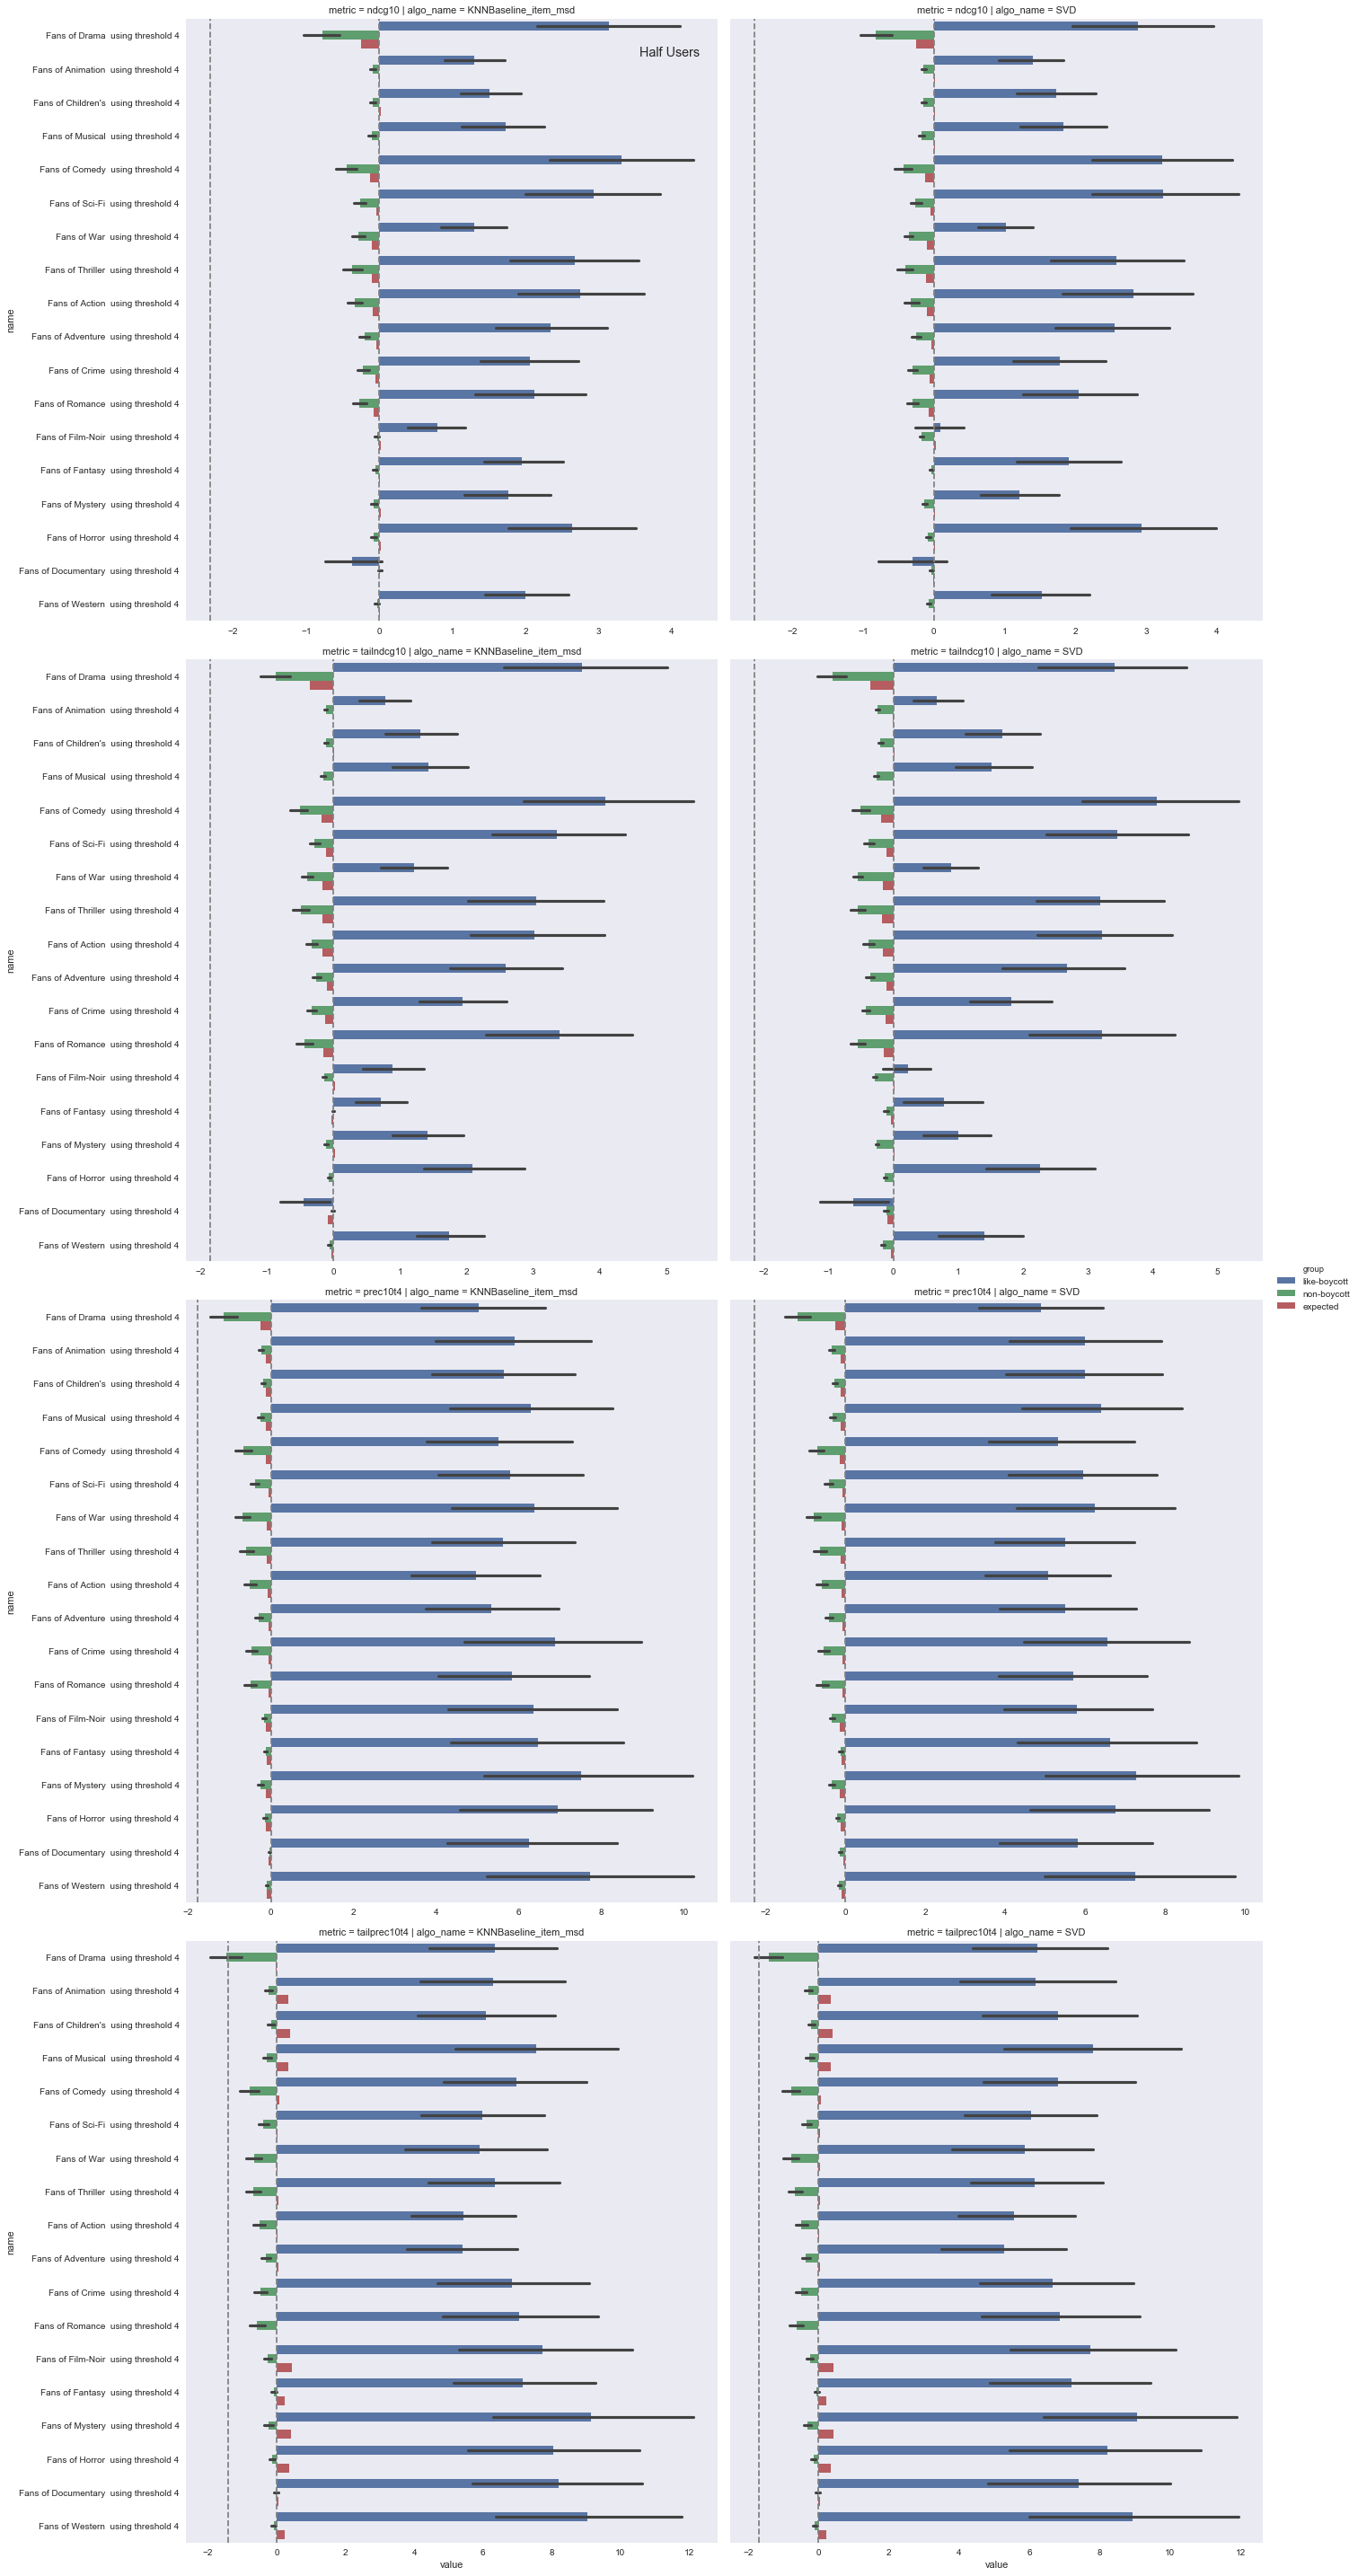

In [1196]:
plot_all_three_scenarios(genre_boycotts, size=10)

In [1197]:
# plot_all_three_scenarios(genre_strict_boycotts, size=10)